In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import os, gc

In [2]:
results_p = 'tpc-di_results/results_with_partition_tpc_di_historical_load_v2.2.1.xlsx'
results = 'tpc-di_results/results_without_partition_tpc_di_historical_load_v2.3.xlsx'

# data

In [7]:
data=pd.concat([pd.read_excel(results).assign(PART='No_Partition'),
                pd.read_excel(results_p).dropna(axis=1, how='all').assign(PART='With_Partition')])
data.columns=data.columns.map(lambda x: x.replace(' ','_').lower())
data.drop(columns=['dag_id'], inplace=True)
data['start_date']=pd.to_datetime(data['start_date'].str.split('.').str[0].str.replace('T','-2022 '))
data['end_date']=pd.to_datetime(data['end_date'].str.split('.').str[0].str.replace('T','-2022 '))
data['subtype']=data.task_id.str.split('_').str[0].map({'load':'load',
                                        'transform':'transform','populate':'transform',
                                        'prep':'transform','financial':'transform',
                                        'convert':'transform'
                                                       }).fillna('interim')
data.loc[data['task_id'].str.contains('json|xml'),'subtype']='transform'
data.loc[(data.subtype=='load')&(data.task_id.str.contains('master')),'subtype']='load_master'
data.loc[(data.subtype=='load')&(~data.task_id.str.contains('master')),'subtype']='load_staging'

data

sf                               task_id               execution_date  \
0    SF30        populate_dimessages_in_master   12-28T23:43:29.604623+00:00   
1    SF30     transform_factholdings_to_master   12-28T23:43:29.604623+00:00   
2    SF30         transform_dimtrade_to_master   12-28T23:43:29.604623+00:00   
3    SF30  transform_fastcasbalances_to_master   12-28T23:43:29.604623+00:00   
4    SF30      transform_factwatches_to_master   12-28T23:43:29.604623+00:00   
..    ...                                   ...                          ...   
205   SF3           load_batch_date_to_staging   12-28T22:49:08.459931+00:00   
206   SF3        load_watch_history_to_staging   12-28T22:49:08.459931+00:00   
207   SF3                   load_hr_to_staging   12-28T22:49:08.459931+00:00   
208   SF3                 create_master_tables   12-28T22:49:08.459931+00:00   
209   SF3                create_staging_tables   12-28T22:49:08.459931+00:00   

                                 operator          start_date  \
0                        BigQueryOperator 2022-12-28 23:48:47   
1                        BigQueryOperator 2022-12-28 23:47:09   
2                        BigQueryOperator 2022-12-28 23:46:33   
3                        BigQueryOperator 2022-12-28 23:46:33   
4                        BigQueryOperator 2022-12-28 23:46:21   
..                                    ...                 ...   
205  GoogleCloudStorageToBigQueryOperator 2022-12-28 22:49:43   
206  GoogleCloudStorageToBigQueryOperator 2022-12-28 22:49:43   
207  GoogleCloudStorageToBigQueryOperator 2022-12-28 22:49:43   
208                      BigQueryOperator 2022-12-28 22:49:15   
209                      BigQueryOperator 2022-12-28 22:49:15   

               end_date         duration  job_id      hostname unixname  \
0   2022-12-28 23:48:52  00:00:05.777000    2099  efd50525a448  airflow   
1   2022-12-28 23:47:19  00:00:10.811000    2098  efd50525a448  airflow   
2   2022-12-28 23:46:59  00:00:26.077000    2097  efd50525a448  airflow   
3   2022-12-28 23:46:59  00:00:26.126000    2096  efd50525a448  airflow   
4   2022-12-28 23:46:42  00:00:21.010000    2095  efd50525a448  airflow   
..                  ...              ...     ...           ...      ...   
205 2022-12-28 22:49:50  00:00:07.193000    1853  efd50525a448  airflow   
206 2022-12-28 22:49:55  00:00:12.295000    1852  efd50525a448  airflow   
207 2022-12-28 22:49:50  00:00:07.373000    1851  efd50525a448  airflow   
208 2022-12-28 22:49:36  00:00:20.868000    1850  efd50525a448  airflow   
209 2022-12-28 22:49:26  00:00:10.748000    1849  efd50525a448  airflow   

     priority_weight    queue                  queued_dttm  try_number  \
0                  1  default  12-28T23:48:44.615212+00:00           2   
1                  2  default  12-28T23:47:06.500951+00:00           2   
2                  3  default  12-28T23:46:30.467467+00:00           2   
3                  1  default  12-28T23:46:30.467421+00:00           2   
4                  1  default  12-28T23:46:18.455434+00:00           2   
..               ...      ...                          ...         ...   
205                2  default  12-28T22:49:30.546359+00:00           2   
206                2  default  12-28T22:49:30.546190+00:00           2   
207                7  default  12-28T22:49:30.546284+00:00           2   
208               20  default  12-28T22:49:12.508939+00:00           2   
209               35  default  12-28T22:49:12.508879+00:00           2   

             pool            part       subtype  
0    default_pool    No_Partition     transform  
1    default_pool    No_Partition     transform  
2    default_pool    No_Partition     transform  
3    default_pool    No_Partition     transform  
4    default_pool    No_Partition     transform  
..            ...             ...           ...  
205  default_pool  With_Partition  load_staging  
206  default_pool  With_Partition  load_staging  
207  default_pool  With_P

# line graph

In [8]:
df=(
    data
    .assign(sorter=lambda x: x.sf.str[2:].astype(int))
    .groupby(['part','sorter','sf'])
    .agg({'start_date':min, 'end_date':max})
    .assign(duration=lambda x: (x.end_date-x.start_date)/np.timedelta64(1,'m'))
    .reset_index()
    .drop(columns='sorter')
)
df

part    sf          start_date            end_date  duration
0    No_Partition   SF3 2022-12-28 17:46:24 2022-12-28 17:55:15  8.850000
1    No_Partition   SF5 2022-12-28 18:04:04 2022-12-28 18:07:04  3.000000
2    No_Partition  SF10 2022-12-28 18:14:11 2022-12-28 18:17:27  3.266667
3    No_Partition  SF20 2022-12-28 18:21:29 2022-12-28 18:25:29  4.000000
4    No_Partition  SF30 2022-12-28 23:43:37 2022-12-28 23:48:52  5.250000
5  With_Partition   SF3 2022-12-28 22:49:15 2022-12-28 22:52:07  2.866667
6  With_Partition   SF5 2022-12-28 22:53:41 2022-12-28 22:56:41  3.000000
7  With_Partition  SF10 2022-12-28 22:57:42 2022-12-28 23:00:48  3.100000
8  With_Partition  SF20 2022-12-28 23:02:10 2022-12-28 23:05:58  3.800000
9  With_Partition  SF30 2022-12-28 23:36:24 2022-12-28 23:41:08  4.733333

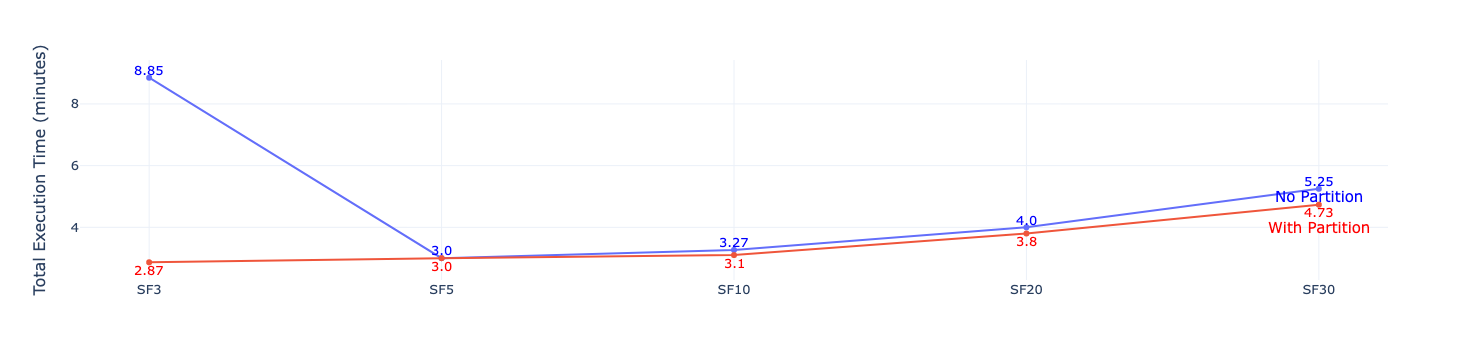

In [9]:
fig=px.line(df.assign(text=df.duration.round(2)), 'sf', 'duration', color='part', markers=True, 
#             text='text'
           )
fig.update_layout(template='plotly_white',
                 yaxis_title='Total Execution Time (minutes)',
                  xaxis_title='',
                  showlegend=False,
                  font=dict(size=13)
                 )

fig.add_annotation(x=4, y=5,
            text="No Partition",
            showarrow=False,
                   font=dict(color='blue', size=15)
                  )

fig.add_annotation(x=4, y=4,
            text="With Partition",
            showarrow=False,
                   font=dict(color='red', size=15)
                  )

for x,y in zip(fig.data[0]['x'], fig.data[0]['y']):
    fig.add_annotation(x=x, 
                       y=y+0.25,
                       xref='x',
                       yref='y',
                text=round(y, 2),
                showarrow=False,
                       font=dict(color='blue', size=13)
                      )
    
for x,y in zip(fig.data[1]['x'], fig.data[1]['y']):
    fig.add_annotation(x=x, 
                       y=y-0.25,
                       xref='x',
                       yref='y',
                text=round(y, 2),
                showarrow=False,
                       font=dict(color='red', size=13)
                      )

# fig.update_traces(textposition='top center')

fig.show(config={'editable':True})

# bar plot changes

In [10]:
from plotly.offline import iplot
from plotly import graph_objs as go

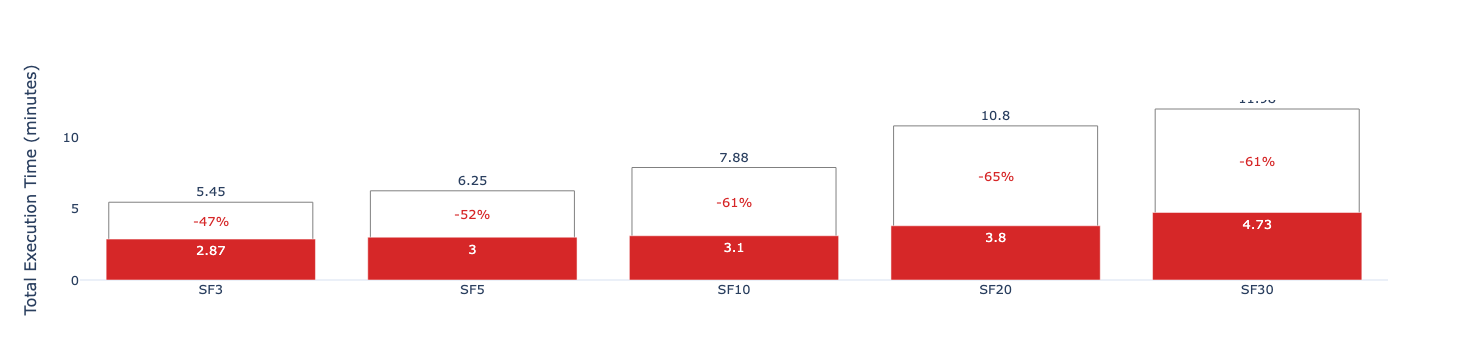

In [11]:
part="With_Partition"
color={'With_Partition':'#d62728','No_Partition':'#636EFA'}[part]

df=(
    data
    .assign(sorter=lambda x: x.sf.str[2:].astype(int),
           duration=(data.duration).apply(lambda t: (t.hour * 60 + t.minute) * 60 + t.second)
           )
    .groupby(['part','sorter','sf'])
    .agg({'start_date':min, 'end_date':max,'duration':sum})
    .assign(duration_seq=lambda x: x.duration/60)
    .assign(duration=lambda x: (x.end_date-x.start_date)/np.timedelta64(1,'m'),
           perc_diff=lambda x: 100*(x.duration-x.duration_seq)/x.duration_seq
           )
    .reset_index()
    .drop(columns='sorter')
    .query('part==@part')
)
df

fig_data = [
    go.Bar(x=df.sf, y=df.duration_seq, name='Sequential',  
            #base=0
           text=df.duration_seq.round(2),
           textposition='outside',
           marker=dict(color='white',
                      line_width=1, line_color='gray'),
           width=0.78
           ),
    go.Bar(x=df.sf, y=df.duration, name='Parallel',  
            #base=0
           text=df.duration.round(2),
           marker=dict(color=color),
           width=0.8
           ),
]

fig_layout = go.Layout(
    barmode='overlay',
)

fig = dict(data = fig_data, layout = fig_layout)
fig=go.Figure(fig)

for x, y, t in zip(df.sf, df.duration+((df.duration_seq-df.duration)/2), df.perc_diff):
    fig.add_annotation(x=x, 
                       y=y,
                       xref='x',
                       yref='y',
                text=f"{int(round(t))}%",
                showarrow=False,
                       font=dict(color=color, size=13)
                      )

fig.update_layout(template='plotly_white',
                 yaxis_title='Total Execution Time (minutes)',
                  xaxis_title='',
                  showlegend=False,
                  font=dict(size=13),
                  width=700,
                  bargap=0,
                  yaxis_showgrid=False
                 )

# gantt chart
- just change filter criteria in query
- run data section first

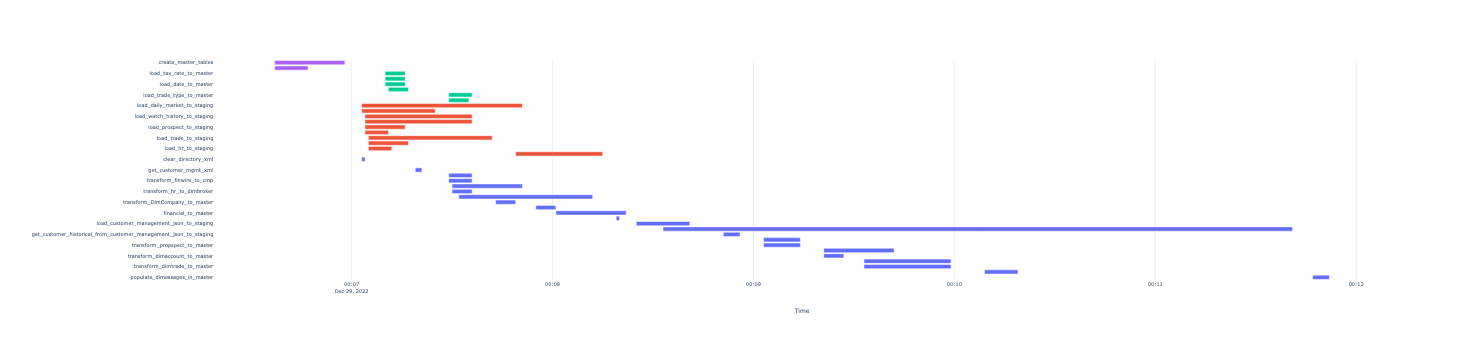

In [12]:

df=(data.query('(sf=="SF30")&(part=="No_Partition")')
                .sort_values(by=['start_date','end_date'], ascending=[False,True])
                .assign(start_date=lambda x: x.start_date+pd.DateOffset(hours=1)+pd.DateOffset(minutes=-37),
                            end_date=lambda x: x.end_date+pd.DateOffset(hours=1)+pd.DateOffset(minutes=-37)
                       ))
fig=px.timeline(df
                ,
                color='subtype'
                , 
                category_orders={j:i for i,j in df.task_id.to_dict().items()}
                ,
                x_start='start_date', x_end='end_date', y='task_id')
fig.update_layout(template='plotly_white',
                 yaxis_title='',
                  xaxis_title='Time',
                  showlegend=False,
                  font=dict(size=5)
                 )
fig.show(config={'editable':True})

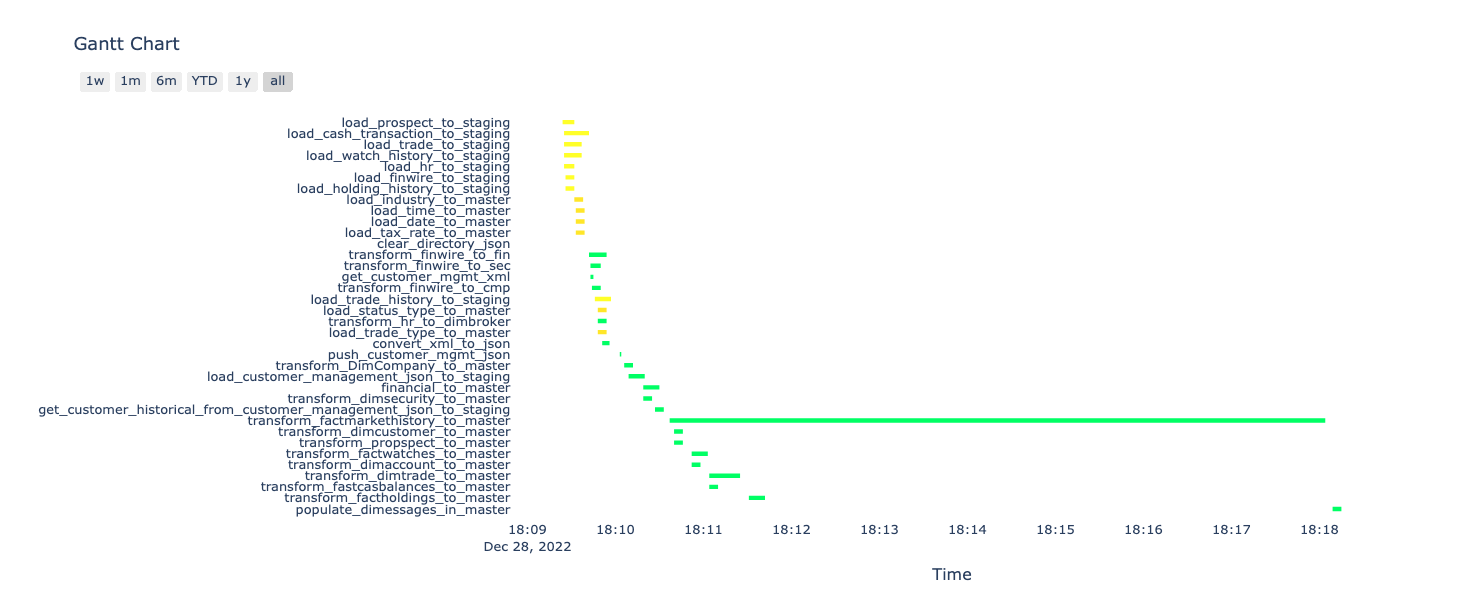

In [13]:
import plotly.figure_factory as ff

colors = {'interim': 'rgb(220, 0, 0)',
          'load_staging': (1, 1, 0.16),
          'load_master': (1, 0.9, 0.16),
          'transform': 'rgb(0, 255, 100)'}

df=(data
    .query('(sf=="SF3")&(part=="No_Partition")')
    .sort_values(by=['start_date','end_date'], ascending=[False,True])
    .assign(start_date=lambda x: x.start_date+pd.DateOffset(hours=1)+pd.DateOffset(minutes=-37),
                            end_date=lambda x: x.end_date+pd.DateOffset(hours=1)+pd.DateOffset(minutes=-37)
                       )
    .rename(columns={'task_id':'Task', 'start_date':'Start',
                   'end_date':'Finish', 'subtype':'Resource'})[['Task','Start','Finish','Resource']]
    .to_dict('records')
   )
fig = ff.create_gantt(df, colors=colors, index_col='Resource', show_colorbar=True,
                      group_tasks=False)
fig.update_layout(template='plotly_white',
                 yaxis_title='',
                  xaxis_title='Time',
                  showlegend=False,
                  font=dict(size=13)
                 )
fig.show()

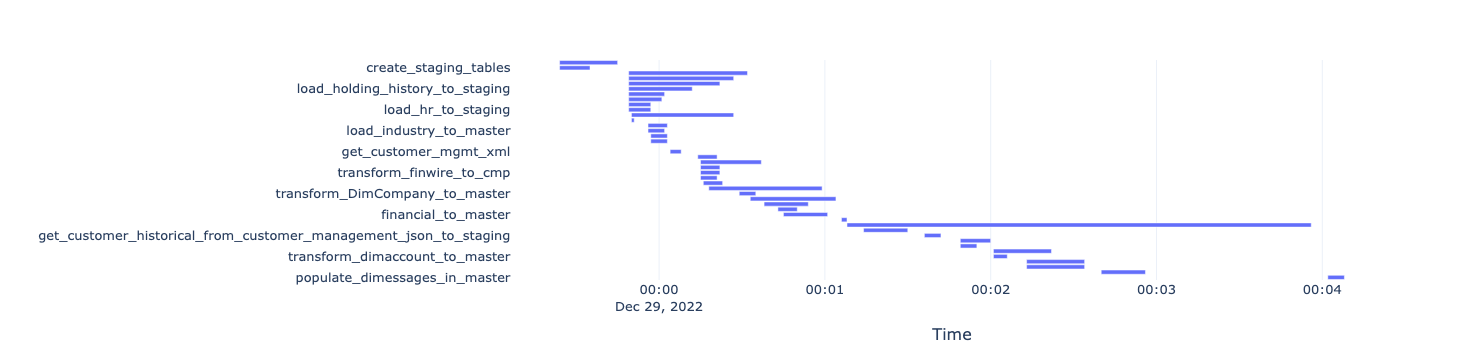

In [14]:
fig=px.timeline(data.query('(sf=="SF30")&(part=="With_Partition")')
                    .assign(start_date=lambda x: x.start_date+pd.DateOffset(hours=1)+pd.DateOffset(minutes=-37),
                            end_date=lambda x: x.end_date+pd.DateOffset(hours=1)+pd.DateOffset(minutes=-37)
                           )
                .sort_values(by=['start_date','end_date'], ascending=[False,True])
                , 
#                 color='subtype',
                
                x_start='start_date', x_end='end_date', y='task_id', 
#                 color_discrete_sequence=['#d62728']
               )
fig.update_layout(template='plotly_white',
                 yaxis_title='',
                  xaxis_title='Time',
                  showlegend=False,
                  font=dict(size=13)
                 )
fig.show(config={'editable':True})

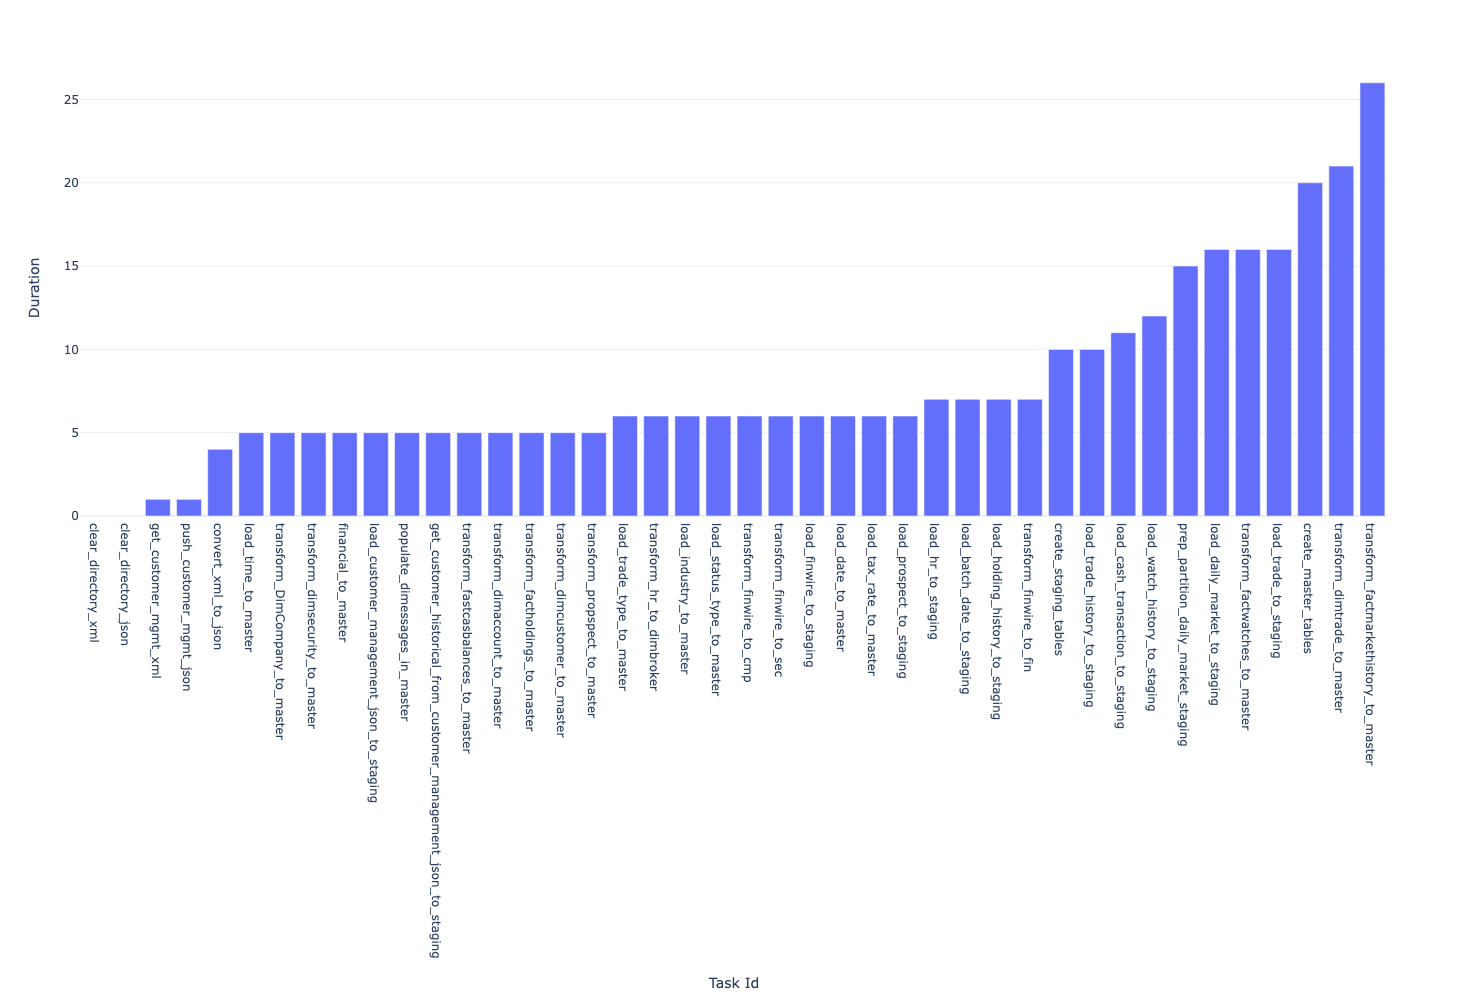

In [45]:
df_bar = data.query('(sf=="SF30")&(part=="With_Partition")')
df_bar.duration = df_bar.duration.apply(lambda t: (t.hour * 60 + t.minute) * 60 + t.second)
df_bar = df_bar.sort_values(by='duration')
fig = px.bar(df_bar, x='task_id', y='duration',width=1200, height=1000)
fig.update_layout(template='plotly_white',
                 yaxis_title='Duration',
                 xaxis_title='Task Id',
                  showlegend=False,
                  #font=dict(size=13)
                 )
fig.show(config={'editable':True})

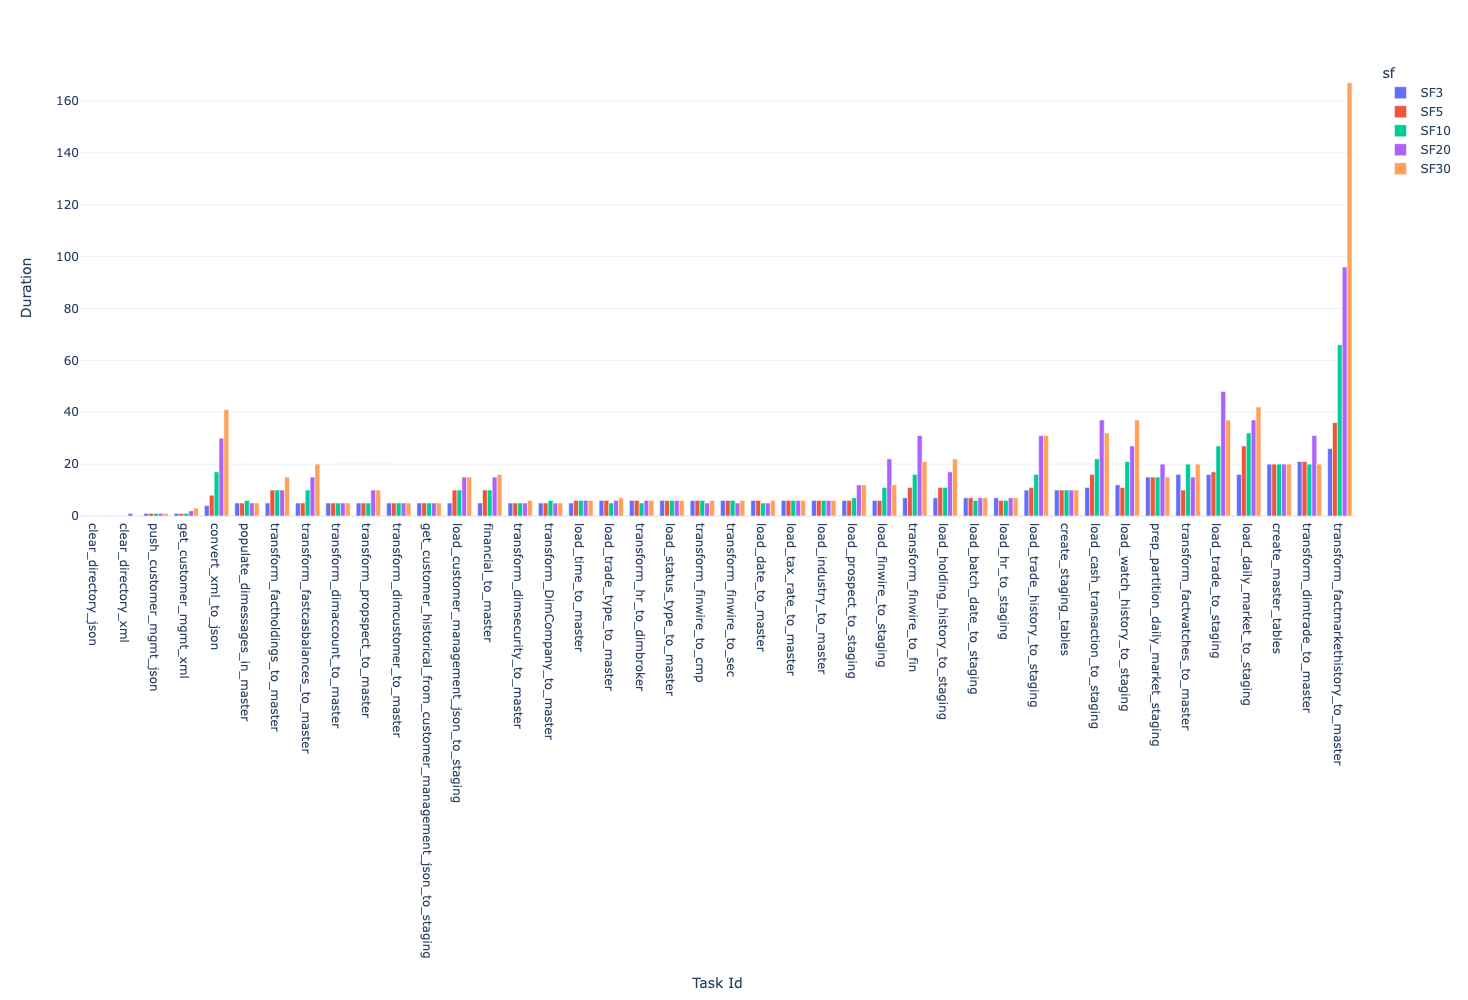

In [61]:
df_bar = data.query('(part=="With_Partition")')
df_bar['sf'] = pd.Categorical(df_bar['sf'], ["SF3", "SF5", "SF10","SF20","SF30"])
df_bar.duration = df_bar.duration.apply(lambda t: (t.hour * 60 + t.minute) * 60 + t.second)
df_bar = df_ba10sort_values9y=[ion','duration'])
fig = px.bar(df_bar, x='task_id', y='duration',width=1200, height=1000,color = 'sf',barmode='group')
fig.update_layout(template='plotly_white',
                 yaxis_title='Duration',
                 xaxis_title='Task Id',
                  showlegend=True,
                  #font=dict(size=13)
                 )
fig.show(config={'editable':True})

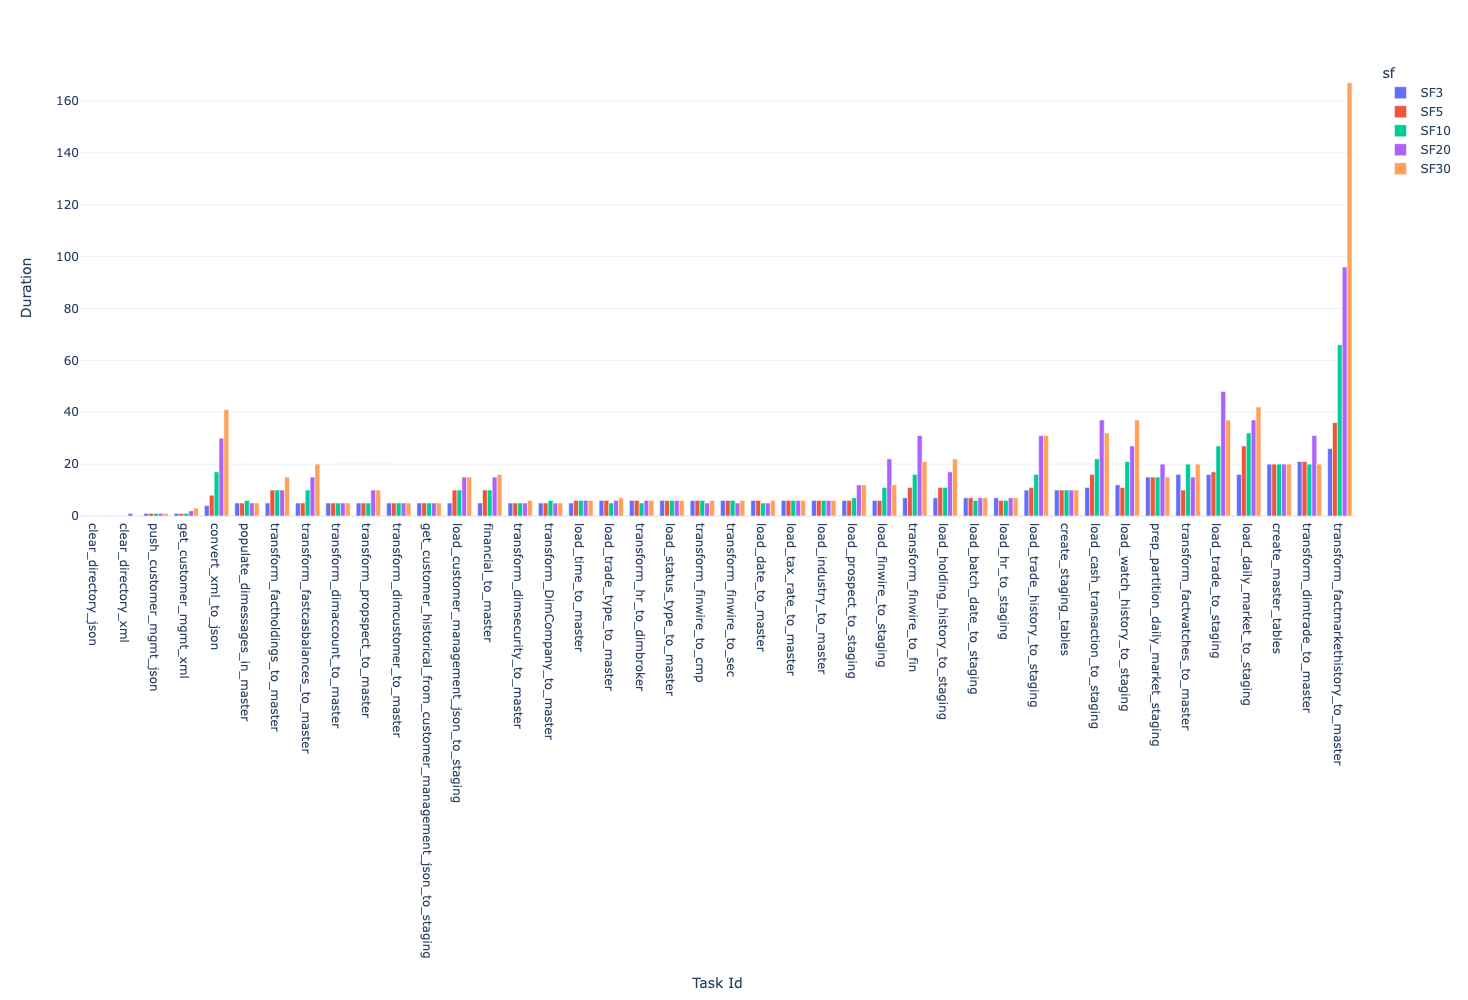

In [61]:
df_bar = data.query('(part=="With_Partition")')
df_bar['sf'] = pd.Categorical(df_bar['sf'], ["SF3", "SF5", "SF10","SF20","SF30"])
df_bar.duration = df_bar.duration.apply(lambda t: (t.hour * 60 + t.minute) * 60 + t.second)
df_bar = df_ba10sort_values9y=[ion','duration'])
fig = px.bar(df_bar, x='task_id', y='duration',width=1200, height=1000,color = 'sf',barmode='group')
fig.update_layout(template='plotly_white',
                 yaxis_title='Duration',
                 xaxis_title='Task Id',
                  showlegend=True,
                  #font=dict(size=13)
                 )
fig.show(config={'editable':True})

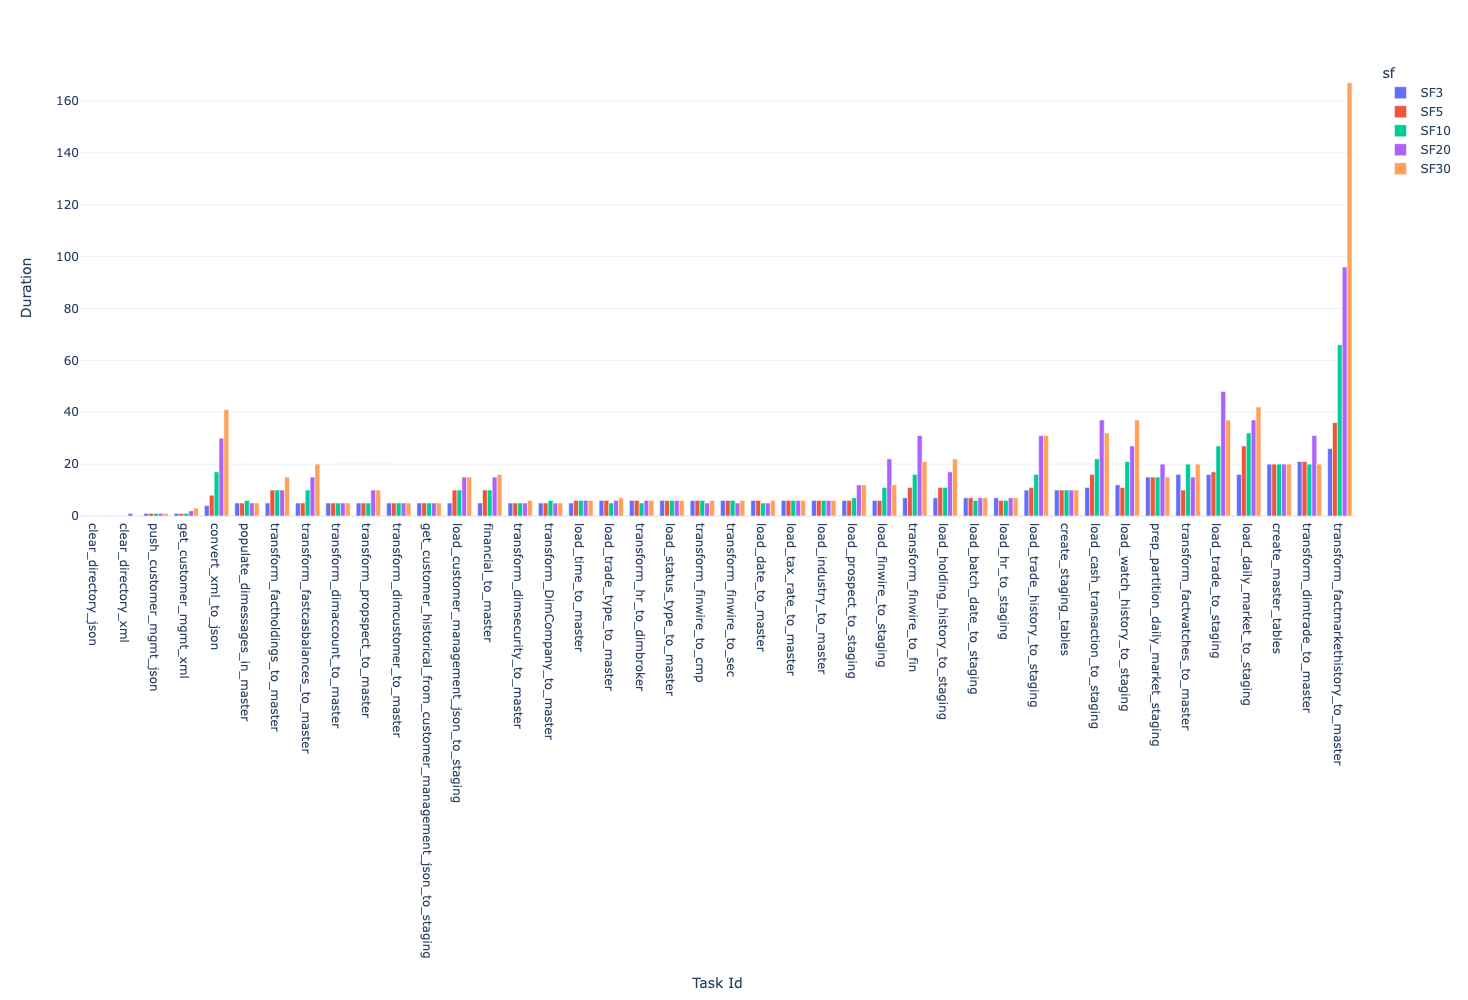

In [61]:
df_bar = data.query('(part=="With_Partition")')
df_bar['sf'] = pd.Categorical(df_bar['sf'], ["SF3", "SF5", "SF10","SF20","SF30"])
df_bar.duration = df_bar.duration.apply(lambda t: (t.hour * 60 + t.minute) * 60 + t.second)
df_bar = df_ba10sort_values9y=[ion','duration'])
fig = px.bar(df_bar, x='task_id', y='duration',width=1200, height=1000,color = 'sf',barmode='group')
fig.update_layout(template='plotly_white',
                 yaxis_title='Duration',
                 xaxis_title='Task Id',
                  showlegend=True,
                  #font=dict(size=13)
                 )
fig.show(config={'editable':True})